# The basics of Amortized Bayesian Inference (ABI)

> The current adage is that *Bayesian models are limited only by the
> user’s imagination*.

That is how Lee & Wagenmakers (2013, p. 7) introduce Markov chain Monte
Carlo (MCMC), and how it allowed widespread adoption of Bayesian
statistics. MCMC indeed allowed Bayesian estimation of models that would
be otherwise impossible to estimate without it. However, if you have
experience with Bayesian modeling, you will probably recognize that the
statement by Lee & Wagenmakers (2013) is a hyperbole. There are many
models one could think of that are impossible to fit even with the
current state-of-the-art MCMC methods. Broadly speaking, MCMC may not be
suitable for two possible reasons: (1) the likelihood of the model is
analytically/computationally intractable, or (2) fitting the model using
MCMC takes too much computational resources.

## Simulation-based inference

*Simulation-based inference* (SBI) is a term for methods that allow
inferences for models whose likelihoods are not analytically tractable
(Cranmer et al., 2020; Lavin et al., 2021). As such, they are sometimes
referred to as *“likelihood-free”*. The basic idea behind SBI methods is
that instead of evaluating the likelihood function, we *sample* values
from a simulation program that represents our statistical model. Using
these simulated values, we make inferences about observed data. A simple
example of a valid SBI method is *rejection sampling*. Consider the
following beta-binomial model:

The posterior of $\theta$ given some number of successes $k$ is
analytically tractable
$\theta \mid k \sim \text{Beta}(1 + k, 1 + 10 - k)$. Using rejection
sampling, we would first draw samples
$(\theta^{(s)}, k^{(s)}) \sim p(\theta, k)$, which is exactly the model
we specified above. At this point, the distribution of $\theta^{(s)}$ is
equal to the prior distribution. Next, we *reject* all simulated samples
$s$ where $k^{(s)}$ is not equal to the observed data. In other words,
we only retain samples $\theta^{(s)}$ which generated $k^{(s)}$ that
correspond to the observed data $k$. By doing so, we *condition* the
distribution of $\theta^{(s)}$ on $k$, an obtain samples from the
posterior $p(\theta \mid k)$ instead.

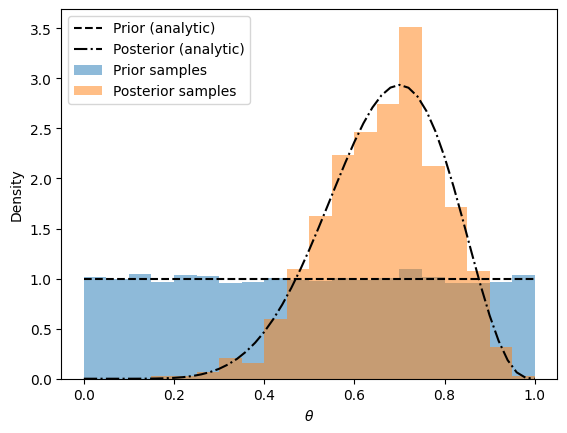

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# sample from the joint model
prior = np.random.beta(a=1,b=1, size=10_000)
prior_predictives = np.random.binomial(n=10, p=prior)

# rejection sampling
observed = 7
posterior = prior[prior_predictives == observed]

# plot results
x = np.linspace(0, 1, 51)
plt.plot(x, beta.pdf(x, a=1, b=1), label="Prior (analytic)", c="black", ls="--")
plt.plot(x, beta.pdf(x, a=1+observed, b=1+10-observed), label="Posterior (analytic)", c="black", ls="-.")
plt.hist(prior,     density=True, alpha=0.5, bins=np.linspace(0, 1, 21), label="Prior samples")
plt.hist(posterior, density=True, alpha=0.5, bins=np.linspace(0, 1, 21), label="Posterior samples")
plt.xlabel("$\\theta$")
plt.ylabel("Density")
f=plt.legend()

Notice that when doing rejection sampling, we never needed to evaluate
the beta prior or the binomial likelihood – we only need to sample
values from them.

Of course, rejection sampling does not work this well in other
scenarios. For example, when the data is continuous and not discrete, it
is futile do to rejection sampling by throwing away samples where the
simulated data does not equal the observed data, as we would almost
surely ended up with an empty set. Similar issue arises when the data
and parameter space is multidimensional. The volume of the space from
which we sample becomes incredibly sparse and rejection sampling becomes
unfeasibly ineffective.

Approximate Bayesian Computation (ABC) is a collection of techniques
that generalize the idea of rejection sampling. Typically, in an ABC
setup, we would use *summary* of the data instead of the raw data (e.g.,
computing means and standard deviations would be sufficient to summarise
data coming from a Gaussian model). Then, instead of testing equality to
observed (summary of) data, we would retain samples for which a
discrepancy measure between the simulated and observed values do not
exceed some threshold. Provided we select an approprioate summary
function, discrepancy measure, and small enough threshold, we will
obtain valid approximations of the posterior distributions.

Other SBI methods rely on approximating the likelihood function using
the simulations, and using that approximation as a replacement for true
model likelihood in traditional estimation methods (e.g, MCMC). A common
issue with these SBI methods is that they become inefficient for complex
models, typically much more time consuming than likelihood-based (e.g.,
pure MCMC) methods.

### Amortized Bayesian Inference

Amortized Bayesian inference (ABI) is a special case of SBI (Radev et
al., 2020; Radev, Schmitt, Schumacher, et al., 2023). In short, ABI
relies on generative neural networks. Generative neural networks are
deep learning architectures that specialize in generating arbitrary
probability distributions. In ABI, our aim is to generate the posterior
distributions of the parameters given data, $p(\theta \mid y)$. These
networks must be trained in order to approximate the posterior
distribution.

During training, we use simulated values of the parameters $\theta$ and
data $y$ drawn from the statistical model. This step usually takes
considerable time since we need to train the network on many simulated
examples, and perform optimization of the networks so as to improve our
approximation.

Once the network is trained, it can be applied to real data to obtain
the posterior distribution of the parameters. At no point during
training or inference we need to evaluate the likelihood, we only need
the simulated values during training. Additionally, the inference is
very fast, typically ranging from milliseconds to seconds. This makes
ABI attractive not only in situations where the likelihood is not
tractable, but also in situations when we need to obtain posterior
distributions *fast*, e.g., when we fit the model repeatedly on multiple
datasets, or when we need to make inferences on the fly.

<figure>
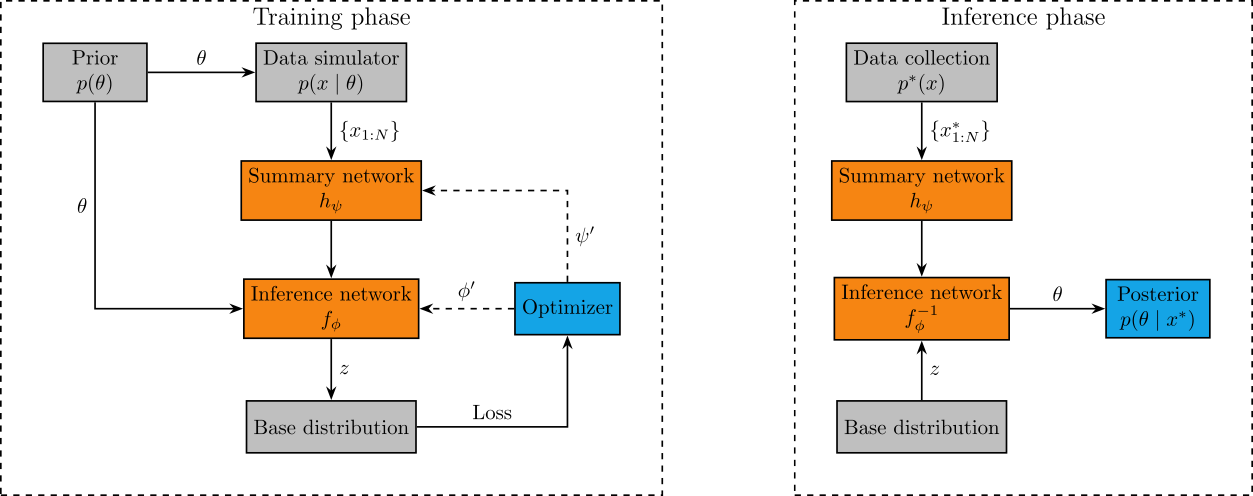
<figcaption aria-hidden="true">Two stages of ABI. First, we train neural
networks on simulated tuples of parameters <span
class="math inline"><em>θ</em></span> and data <span
class="math inline"><em>x</em></span>. Once trained, the neural networks
can be used to generate the posterior distribution of parameters <span
class="math inline"><em>θ</em></span> given observed data <span
class="math inline"><em>x</em></span>, <span
class="math inline"><em>p</em>(<em>y</em> ∣ <em>x</em>)</span>.</figcaption>
</figure>

The input of the inference networks can be raw data, hand crafted
summary statistics, summary statistics provided by another network that
can be trained together with the inference network, or combination of
those. In addition to being able to approximate the posterior
distribution of parameters, it can be efficiently used for other goals,
such as marginal likelihood estimation, surrogate likelihood, posterior
predictive simulation, and more (Radev, Schmitt, Pratz, et al., 2023).

We recommend reading through the articles that introduce it in more
technical detail (e.g., Radev et al., 2020; Radev, Schmitt, Schumacher,
et al., 2023; Radev, Schmitt, Pratz, et al., 2023).

Cranmer, K., Brehmer, J., & Louppe, G. (2020). The frontier of
simulation-based inference. *Proceedings of the National Academy of
Sciences*, *117*(48), 30055–30062.

Lavin, A., Krakauer, D., Zenil, H., Gottschlich, J., Mattson, T.,
Brehmer, J., Anandkumar, A., Choudry, S., Rocki, K., Baydin, A. G., et
al. (2021). Simulation intelligence: Towards a new generation of
scientific methods. *arXiv Preprint arXiv:2112.03235*.

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.

Radev, S. T., Mertens, U. K., Voss, A., Ardizzone, L., & Köthe, U.
(2020). BayesFlow: Learning complex stochastic models with invertible
neural networks. *IEEE Transactions on Neural Networks and Learning
Systems*, *33*(4), 1452–1466.

Radev, S. T., Schmitt, M., Pratz, V., Picchini, U., Koethe, U., &
Buerkner, P.-C. (2023). JANA: Jointly amortized neural approximation of
complex bayesian models. *The 39th Conference on Uncertainty in
Artificial Intelligence*. <https://openreview.net/forum?id=dS3wVICQrU0>

Radev, S. T., Schmitt, M., Schumacher, L., Elsemüller, L., Pratz, V.,
Schälte, Y., Köthe, U., & Bürkner, P.-C. (2023). *BayesFlow: Amortized
bayesian workflows with neural networks*. arXiv.
<https://arxiv.org/abs/2306.16015>